NESTML active dendrite third-factor STDP synapse
==========================================

In this tutorial, a 

<a name="introduction"></a>

Introduction
------------


In [1]:
%matplotlib inline

from typing import List, Optional

import matplotlib as mpl

mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = [8., 3.]

import matplotlib.pyplot as plt
import nest
import numpy as np
import os
import random
import re

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils
from pynestml.codegeneration.nest_tools import NESTTools

/home/charl/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Nov  8 2023 01:11:46

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
post_trace_var = "I_dend"

## Generating code with NESTML

We will take a simple current-based integrate-and-fire model with alpha-shaped postsynaptic response kernels (``iaf_psc_alpha``) as the basis for our modifications. First, let's take a look at this base neuron without any modifications.

We will use a helper function to generate the C++ code for the models, build it as a NEST extension module, and load the module into the kernel. Because NEST does not support un- or reloading of modules at the time of writing, we implement a workaround that appends a unique number to the name of each generated model, for example, "iaf_psc_alpha_3cc945f". The resulting neuron model name is returned by the function, so we do not have to think about these internals.

In [3]:
%pdb
# codegen_opts = {"neuron_synapse_pairs": [{"neuron": "iaf_psc_exp_dend",
#                                           "synapse": "third_factor_stdp_synapse",
#                                           "post_ports": ["post_spikes",
#                                                          ["I_post_dend", "I_dend"]]}]}

# if not NESTTools.detect_nest_version().startswith("v2"):
#     codegen_opts["neuron_parent_class"] = "StructuralPlasticityNode"
#     codegen_opts["neuron_parent_class_include"] = "structural_plasticity_node.h"

# generate the "jit" model (co-generated neuron and synapse), that does not rely on ArchivingNode
# files = [os.path.join("models", "neurons", "iaf_psc_exp_dend_neuron.nestml"),
#          os.path.join("models", "synapses", "third_factor_stdp_synapse.nestml")]
# input_path = [os.path.realpath(os.path.join(os.path.dirname(__file__), os.path.join(
#     os.pardir, os.pardir, s))) for s in files]
# generate_nest_target(input_path=input_path,
#                      target_path="/tmp/nestml-jit",
#                      logging_level="INFO",
#                      module_name="nestml_jit_module",
#                      codegen_opts=codegen_opts)
#nest.Install("nestml_jit_module")

# generate and build code
module_name, neuron_model_name, synapse_model_name = \
    NESTCodeGeneratorUtils.generate_code_for("../../../models/neurons/iaf_psc_exp_dend_neuron.nestml",
                                             "../../../models/synapses/third_factor_stdp_synapse.nestml",
                                             logging_level="DEBUG",
                                             post_ports=["post_spikes", ["I_post_dend", "I_dend"]])

# load dynamic library (NEST extension module) into NEST kernel
nest.Install(module_name)

Automatic pdb calling has been turned ON
[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /home/charl/julich/nestml-fork-clopath_synapse/nestml/doc/tutorials/stdp_third_factor_active_dendrite/iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron.nestml
[3,GLOBAL, INFO]: /home/charl/julich/nestml-fork-clopath_synapse/nestml/doc/tutorials/stdp_third_factor_active_dendrite/third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse.nestml
[4,GLOBAL, INFO]: Target platform code will be generated in directory: '/home/charl/julich/nestml-fork-clopath_synapse/nestml/doc/tutorials/stdp_third_factor_active_dendrite/target'
[5,GLOBAL, INFO]: Target platform code will be installed in directory: '/tmp/nestml_target__g6kk6gx'

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Nov  8 2023 01:11:46

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
  

INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_m' = (-(V_m - E_L)) / tau_m + ((I_kernel_exc__X__exc_spikes * 1.0 - I_kernel_inh__X__inh_spikes * 1.0) + I_e + I_stim) / C_m",
            "initial_values": {
                "V_m": "E_L"
            }
        },
        {
            "expression": "I_kernel_inh__X__inh_spikes = exp(-t / tau_syn_inh)",
            "initial_values": {}
        },
        {
            "expression": "I_kernel_exc__X__exc_spikes = exp(-t / tau_syn_exc)",
            "initial_values": {}
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "C_m": "250",
        "E_L": "(-70)",
        "I_e": "0",
        "V_reset": "(-70)",
        "V_th": "(-55)",
        "refr_T": "2",
        "tau_m": "10",
        "tau_syn_exc": "2",
        "tau_syn_inh": "2"
    }
}
INFO:Processing global options...
INFO:Processing input shapes...
INFO:
Processing differential-equation form sha

[57,third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__with_iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml, DEBUG, [39:0;85:0]]: Start building symbol table!
[58,third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__with_iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml, WARNING, [44:8;44:28]]: Variable 'd' has the same name as a physical unit!
[59,GLOBAL, INFO]: Successfully constructed neuron-synapse pair iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml__with_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml, third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__with_iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml
[60,GLOBAL, INFO]: Analysing/transforming model 'iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml'
[61,iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml, INFO, [38:0;93:0]]: Starts processing of the model 'iaf_psc_exp_dend87df6413058144c

DEBUG:Found t: 0
DEBUG:	Finding ode for order 1...
DEBUG:Shape satisfies ODE of order = 1
DEBUG:Created Shape with symbol I_kernel_inh__X__inh_spikes, derivative_factors = [-1/tau_syn_inh], inhom_term = 0.0, nonlin_term = 0.0
INFO:
Processing function-of-time shape "I_kernel_exc__X__exc_spikes" with defining expression = "exp(-t/tau_syn_exc)"
DEBUG:Found t: 0
DEBUG:	Finding ode for order 1...
DEBUG:Shape satisfies ODE of order = 1
DEBUG:Created Shape with symbol I_kernel_exc__X__exc_spikes, derivative_factors = [-1/tau_syn_exc], inhom_term = 0.0, nonlin_term = 0.0
INFO:Shape V_m: reconstituting expression E_L/tau_m - V_m/tau_m + I_e/C_m + 1.0*I_kernel_exc__X__exc_spikes/C_m - 1.0*I_kernel_inh__X__inh_spikes/C_m + I_stim/C_m
DEBUG:Splitting expression E_L/tau_m - V_m/tau_m + I_e/C_m + 1.0*I_kernel_exc__X__exc_spikes/C_m - 1.0*I_kernel_inh__X__inh_spikes/C_m + I_stim/C_m (symbols Matrix([[V_m], [I_kernel_inh__X__inh_spikes], [I_kernel_exc__X__exc_spikes]]))
DEBUG:	linear factors: Matrix(

[62,iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml, DEBUG, [38:0;93:0]]: Start building symbol table!


INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_m' = (-(V_m - E_L)) / tau_m + ((I_kernel_exc__X__exc_spikes * 1.0 - I_kernel_inh__X__inh_spikes * 1.0) + I_e + I_stim) / C_m",
            "initial_values": {
                "V_m": "E_L"
            }
        },
        {
            "expression": "post_trace_kernel__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__X__post_spikes__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml = exp(-t / tau_tr_post__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml)",
            "initial_values": {}
        },
        {
            "expression": "I_kernel_inh__X__inh_spikes = exp(-t / tau_syn_inh)",
            "initial_values": {}
        },
        {
            "expression": "I_kernel_exc__X__exc_spikes = exp(-t / tau_syn_exc)",
            "initial_values": {}
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "param

DEBUG:	nonlinear term: 0.0
INFO:Shape post_trace_kernel__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__X__post_spikes__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml: reconstituting expression -post_trace_kernel__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__X__post_spikes__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml/tau_tr_post__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml
DEBUG:Splitting expression -post_trace_kernel__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__X__post_spikes__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml/tau_tr_post__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml (symbols Matrix([[V_m], [post_trace_kernel__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__X__post_spikes__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml], [I_kernel_inh__X__i

[63,GLOBAL, INFO]: Analysing/transforming model 'iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml__with_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml'
[64,iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml__with_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml, INFO, [38:0;93:0]]: Starts processing of the model 'iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml__with_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml'


INFO:Generating propagators for the following symbols: V_m, post_trace_kernel__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__X__post_spikes__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml, I_kernel_inh__X__inh_spikes, I_kernel_exc__X__exc_spikes
DEBUG:Initializing system of shapes with x = Matrix([[V_m], [post_trace_kernel__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__X__post_spikes__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml], [I_kernel_inh__X__inh_spikes], [I_kernel_exc__X__exc_spikes]]), A = Matrix([[-1/tau_m, 0, -1.0/C_m, 1.0/C_m], [0, -1/tau_tr_post__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml, 0, 0], [0, 0, -1/tau_syn_inh, 0], [0, 0, 0, -1/tau_syn_exc]]), b = Matrix([[E_L/tau_m + I_e/C_m + I_stim/C_m], [0.0], [0.0], [0.0]]), c = Matrix([[0], [0], [0], [0]])
DEBUG:System of equations:
DEBUG:x = Matrix([[V_m], [post_trace_kernel__for_third_factor_stdp87df6413058

INFO:
Processing function-of-time shape "pre_trace_kernel__X__pre_spikes" with defining expression = "exp(-t/tau_tr_pre)"
DEBUG:Found t: 0
DEBUG:	Finding ode for order 1...
DEBUG:Shape satisfies ODE of order = 1
DEBUG:Created Shape with symbol pre_trace_kernel__X__pre_spikes, derivative_factors = [-1/tau_tr_pre], inhom_term = 0.0, nonlin_term = 0.0
INFO:Shape pre_trace_kernel__X__pre_spikes: reconstituting expression -pre_trace_kernel__X__pre_spikes/tau_tr_pre
DEBUG:Splitting expression -pre_trace_kernel__X__pre_spikes/tau_tr_pre (symbols Matrix([[pre_trace_kernel__X__pre_spikes]]))
DEBUG:	linear factors: Matrix([[-1/tau_tr_pre]])
DEBUG:	inhomogeneous term: 0.0
DEBUG:	nonlinear term: 0.0
DEBUG:Initializing system of shapes with x = Matrix([[pre_trace_kernel__X__pre_spikes]]), A = Matrix([[-1/tau_tr_pre]]), b = Matrix([[0.0]]), c = Matrix([[0.0]])
INFO:Finding analytically solvable equations...
INFO:Saving dependency graph plot to /tmp/ode_dependency_graph.dot
DEBUG:os.makedirs('/tmp')


[65,iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml__with_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml, DEBUG, [38:0;93:0]]: Start building symbol table!
[66,GLOBAL, INFO]: Analysing/transforming synapse third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__with_iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml.
[67,third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__with_iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml, INFO, [39:0;85:0]]: Starts processing of the model 'third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__with_iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml'


INFO:Shape pre_trace_kernel__X__pre_spikes: reconstituting expression -pre_trace_kernel__X__pre_spikes/tau_tr_pre
DEBUG:Splitting expression -pre_trace_kernel__X__pre_spikes/tau_tr_pre (symbols [pre_trace_kernel__X__pre_spikes])
DEBUG:	linear factors: Matrix([[-1/tau_tr_pre]])
DEBUG:	inhomogeneous term: 0.0
DEBUG:	nonlinear term: 0.0
INFO:Saving dependency graph plot to /tmp/ode_dependency_graph_analytically_solvable_before_propagated.dot
DEBUG:os.makedirs('/tmp')
DEBUG:write lines to '/tmp/ode_dependency_graph_analytically_solvable_before_propagated.dot'
DEBUG:run [PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'ode_dependency_graph_analytically_solvable_before_propagated.dot']
INFO:Saving dependency graph plot to /tmp/ode_dependency_graph_analytically_solvable.dot
DEBUG:os.makedirs('/tmp')
DEBUG:write lines to '/tmp/ode_dependency_graph_analytically_solvable.dot'
DEBUG:run [PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'ode_dependency_graph_analytically_solvable.dot']
INFO:Generating propagat

[68,third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__with_iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml, DEBUG, [39:0;85:0]]: Start building symbol table!
[69,third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__with_iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml, WARNING, [44:8;44:28]]: Variable 'd' has the same name as a physical unit!
[70,third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__with_iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml, DEBUG, [39:0;85:0]]: Start building symbol table!
[71,third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__with_iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml, WARNING, [44:8;44:28]]: Variable 'd' has the same name as a physical unit!
[72,GLOBAL, INFO]: Rendering template /home/charl/julich/nestml-fork-clopath_synapse/nestml/doc/tutorials/stdp_third_factor_active_dendrite/target/iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2dee

In file included from /home/charl/julich/nestml-fork-clopath_synapse/nestml/doc/tutorials/stdp_third_factor_active_dendrite/target/nestml_87df6413058144cdbd49c0ed07b2deee_module.cpp:52:
/home/charl/julich/nestml-fork-clopath_synapse/nestml/doc/tutorials/stdp_third_factor_active_dendrite/target/third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__with_iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml.h: In instantiation of ‘nest::third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__with_iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml<targetidentifierT>::third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml__with_iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml() [with targetidentifierT = nest::TargetIdentifierPtrRport]’:
/home/charl/julich/nest-simulator-install/include/nest/connector_model.h:158:25:   required from ‘nest::GenericConnectorModel<ConnectionT>::GenericConnectorModel(std::string) [with Connection

[100%] Linking CXX shared module nestml_87df6413058144cdbd49c0ed07b2deee_module.so
[100%] Built target nestml_87df6413058144cdbd49c0ed07b2deee_module_module
[100%] Built target nestml_87df6413058144cdbd49c0ed07b2deee_module_module
Install the project...
-- Install configuration: ""
-- Installing: /tmp/nestml_target__g6kk6gx/nestml_87df6413058144cdbd49c0ed07b2deee_module.so
iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml::init_state_internal_()
iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml__with_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml::init_state_internal_()

Jan 11 11:01:59 Install [Info]: 
    loaded module nestml_87df6413058144cdbd49c0ed07b2deee_module


Now, the NESTML model is ready to be used in a simulation.

In [40]:
def run_synapse_test(neuron_model_name,
                        synapse_model_name,
                        resolution=1.,  # [ms]
                        delay=1.,  # [ms]
                        sim_time=None,  # if None, computed from pre and post spike times
                        pre_spike_times=None,
                        post_spike_times=None,
                        fname_snip="",
                        stepwise_times=None, stepwise_values=None, verbose=False):

    if pre_spike_times is None:
        pre_spike_times = []

    if post_spike_times is None:
        post_spike_times = []

    if sim_time is None:
        sim_time = max(np.amax(pre_spike_times), np.amax(post_spike_times)) + 5 * delay

    nest_version = NESTTools.detect_nest_version()

    nest.set_verbosity("M_ALL")
    nest.ResetKernel()

    print("Pre spike times: " + str(pre_spike_times))
    print("Post spike times: " + str(post_spike_times))

    nest.set_verbosity("M_WARNING")

    nest.ResetKernel()
    nest.SetKernelStatus({"resolution": resolution})

    wr = nest.Create("weight_recorder")
    nest.CopyModel(synapse_model_name, "stdp_nestml_rec",
                    {"weight_recorder": wr[0], "w": 1., "d": 1., "receptor_type": 0, "lambda": .001})

    # create spike_generators with these times
    pre_sg = nest.Create("spike_generator",
                            params={"spike_times": pre_spike_times})
    post_sg = nest.Create("spike_generator",
                            params={"spike_times": post_spike_times,
                                    "allow_offgrid_times": True})

    # create parrot neurons and connect spike_generators
    pre_neuron = nest.Create("parrot_neuron")
    post_neuron = nest.Create(neuron_model_name)

    if nest_version.startswith("v2"):
        spikedet_pre = nest.Create("spike_detector")
        spikedet_post = nest.Create("spike_detector")
    else:
        spikedet_pre = nest.Create("spike_recorder")
        spikedet_post = nest.Create("spike_recorder")
    mm = nest.Create("multimeter", params={"record_from": ["V_m", post_trace_var]})

    nest.Connect(pre_sg, pre_neuron, "one_to_one", syn_spec={"delay": 1.})
    nest.Connect(post_sg, post_neuron, "one_to_one", syn_spec={"delay": 1., "weight": 6000.})
    if nest_version.startswith("v2"):
        nest.Connect(pre_neuron, post_neuron, "all_to_all", syn_spec={"model": "stdp_nestml_rec"})
    else:
        nest.Connect(pre_neuron, post_neuron, "all_to_all", syn_spec={"synapse_model": "stdp_nestml_rec"})
    nest.Connect(mm, post_neuron)
    nest.Connect(pre_neuron, spikedet_pre)
    nest.Connect(post_neuron, spikedet_post)

    # get STDP synapse and weight before protocol
    syn = nest.GetConnections(source=pre_neuron, synapse_model="stdp_nestml_rec")

    t = 0.
    t_hist = []
    w_hist = []
    state = 0
    while t <= sim_time:
        if verbose:
            print("t = " + str(t) + " ms")
        if stepwise_times is not None and stepwise_values is not None:
            assert len(stepwise_times) == len(stepwise_values)
            
            if state < len(stepwise_times) - 1 and t >= stepwise_times[state + 1]:
                state += 1

            if stepwise_values[state] is not None:
                nest.SetStatus(post_neuron, {"I_dend": stepwise_values[state]})

        nest.Simulate(resolution)
        t += resolution
        t_hist.append(t)
        w_hist.append(nest.GetStatus(syn)[0]["w"])

    third_factor_trace = nest.GetStatus(mm, "events")[0][post_trace_var]
    timevec = nest.GetStatus(mm, "events")[0]["times"]

    
    
    
    fig, ax = plt.subplots(nrows=2)
    ax1, ax2 = ax

    V_m = nest.GetStatus(mm, "events")[0]["V_m"]
    ax2.plot(timevec, third_factor_trace, label="I_dend_post")
    ax1.plot(timevec, V_m, alpha=.7, linestyle=":")
    ax1.set_ylabel("V_m")

    for _ax in ax:
        _ax.grid(which="major", axis="both")
        _ax.grid(which="minor", axis="x", linestyle=":", alpha=.4)
        _ax.set_xlim(0., sim_time)
        _ax.legend()
    fig.savefig("/tmp/stdp_third_factor_synapse_test" + fname_snip + "_V_m.png", dpi=300)
    
    
    
    fig, ax = plt.subplots(nrows=5)
    ax1, ax2, ax3, ax4, ax5 = ax

    pre_spike_times_ = nest.GetStatus(spikedet_pre, "events")[0]["times"]
    print("Actual pre spike times: " + str(pre_spike_times_))

    n_spikes = len(pre_spike_times_)
    for i in range(n_spikes):
        ax1.plot(2 * [pre_spike_times_[i] + delay], [0, 1], linewidth=2, color="blue", alpha=.4)

    post_spike_times_ = nest.GetStatus(spikedet_post, "events")[0]["times"]
    print("Actual post spike times: " + str(post_spike_times_))
    ax1.set_ylabel("Pre spikes")

    n_spikes = len(post_spike_times_)
    for i in range(n_spikes):
        if i == 0:
            _lbl = "nestml"
        else:
            _lbl = None
        ax[-4].plot(2 * [post_spike_times_[i]], [0, 1], linewidth=2, color="black", alpha=.4, label=_lbl)
    ax[-4].set_ylabel("Post spikes")

    ax[-3].plot(timevec, third_factor_trace)
    ax[-3].set_ylabel("3rd factor")

    ax[-2].semilogy(t_hist[:-1], np.abs(np.diff(w_hist)), marker="o", label=u"Δw")
    #ax[-2].set_yscale('symlog')
    ax[-2].set_ylabel(u"Δw")

    ax[-1].plot(t_hist, w_hist, marker="o")
    ax[-1].set_ylabel("w")
    ax[-1].set_xlabel("Time [ms]")
    for _ax in ax:
        if not _ax == ax[-1]:
            _ax.set_xticklabels([])
        _ax.grid(True)
        _ax.set_xlim(0., sim_time)

    fig.savefig("/tmp/stdp_third_factor_synapse_test" + fname_snip + ".png", dpi=300)

    return timevec, t_hist, third_factor_trace, w_hist


In [5]:
fname_snip = ""

post_spike_times = np.sort(np.unique(1 + np.round(500 * np.sort(np.abs(np.random.randn(500))))))      # [ms]
pre_spike_times = np.sort(np.unique(1 + np.round(500 * np.sort(np.abs(np.random.randn(500))))))      # [ms]

# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(neuron_model_name=neuron_model_name,
                        synapse_model_name=synapse_model_name,
                        resolution=.5,  # [ms]
                        delay=1.5,  # [ms]
                        pre_spike_times=pre_spike_times,
                        post_spike_times=post_spike_times,
                        sim_time=400.,
                        fname_snip=fname_snip)

# verify
assert np.any(np.abs(np.array(w_hist) - 1) > 0.), "No change in the weight!"

# verify that weight does not change appreciably when third factor trace is close to zero
idx = np.where(np.abs(third_factor_trace) < 1E-12)[0]  # find where third_factor_trace is (almost) zero
times_dw_should_be_zero = timevec[idx]
assert len(times_dw_should_be_zero) > 0  # make sure we have > 0 datapoints to check
for time_dw_should_be_zero in times_dw_should_be_zero[1:]:
    _idx = np.argmin((time_dw_should_be_zero - np.array(t_hist))**2)
    np.testing.assert_allclose(t_hist[_idx], time_dw_should_be_zero)
    np.testing.assert_allclose(0., np.abs(w_hist[_idx - 1] - w_hist[_idx]))   # make sure that weight does not change appreciably




              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Nov  8 2023 01:11:46

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[84,GLOBAL, INFO]: The NEST Simulator version was automatically detected as: master
Pre spike times: [   2.    4.    5.    6.    7.    8.   11.   16.   18.   21.   23.   24.
   25.   26.   28.   31.   32.   37.   38.   40.   42.   43.   45.   46.
   50.   51.   52.   53.   54.   55.   56.   58.   60.   62.   64.   65.
   68.   70.   71.   72.   73.   74.   75.   76.   78.   80.   81.   84.
   89.   91.   92.   93.   97.  100.  106.  107.  108.  109.  111.  112.
  113.  115.  116.  123.  124.  127.  128.  131.  132.  134.  135.  136.
  140.  143.  144.  145.  146.  147.  152.  157.  159.  163.  166.  169.
  170.  171.  174.  175.  176.  177.  179.  183

In iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml__with_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml::update: t = 17

Jan 11 11:01:59 SimulationManager::run [Warning]: 
    The requested simulation time is not an integer multiple of the minimal 
    delay in the network. This may result in inconsistent results under the 
    following conditions: (i) A network contains more than one source of 
    randomness, e.g., two different poisson_generators, and (ii) Simulate is 
    called repeatedly with simulation times that are not multiples of the 
    minimal delay.
iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml__with_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml::get_post_trace__for_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml: getting value at t = 16
iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml__with_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml::get_post_trace_

    delay in the network. This may result in inconsistent results under the 
    following conditions: (i) A network contains more than one source of 
    randomness, e.g., two different poisson_generators, and (ii) Simulate is 
    called repeatedly with simulation times that are not multiples of the 
    minimal delay.
In iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml__with_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml::update (dt = 0.5)
In iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml__with_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml::update: t = 31

Jan 11 11:01:59 SimulationManager::run [Warning]: 
    The requested simulation time is not an integer multiple of the minimal 
    delay in the network. This may result in inconsistent results under the 
    following conditions: (i) A network contains more than one source of 
    randomness, e.g., two different poisson_generators, and (ii) Simulate is 
    called

KeyboardInterrupt: 

oisson_generators, and (ii) Simulate is 
    called repeatedly with simulation times that are not multiples of the 
    minimal delay.
[NEST] archivingnode: set_spiketime
In iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml__with_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml::update (dt = 0.5)
In iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml__with_third_factor_stdp87df6413058144cdbd49c0ed07b2deee_synapse_nestml::update: t = 33

Jan 11 11:01:59 SimulationManager::run [Warning]: 
    The requested simulation time is not an integer multiple of the minimal 
    delay in the network. This may result in inconsistent results under the 
    following conditions: (i) A network contains more than one source of 
    randomness, e.g., two different poisson_generators, and (ii) Simulate is 
    called repeatedly with simulation times that are not multiples of the 
    minimal delay.
iaf_psc_exp_dend87df6413058144cdbd49c0ed07b2deee_neuron_nestml__with

Detailed look at the numerics
------------------------
...


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Nov  8 2023 01:11:46

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[97,GLOBAL, INFO]: The NEST Simulator version was automatically detected as: master
Pre spike times: [15.0, 40.0, 70.0, 100.0]
Post spike times: [20.0, 45.0, 75.0]


/tmp/ipykernel_787504/4170563884.py:147: UserWarning:Data has no positive values, and therefore cannot be log-scaled.


Actual pre spike times: [ 16.  41.  71. 101.]
Actual post spike times: [21.8 46.7 76.8]


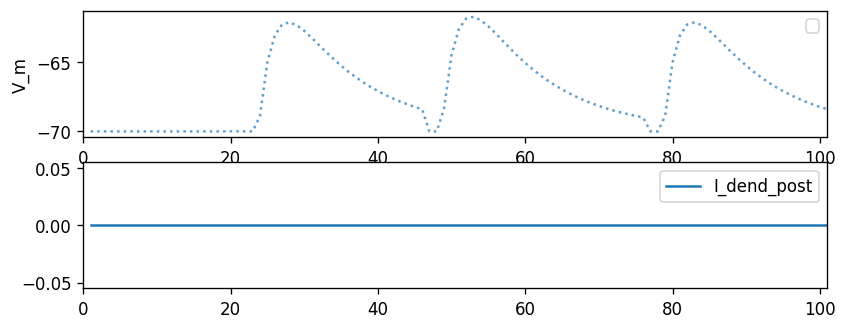

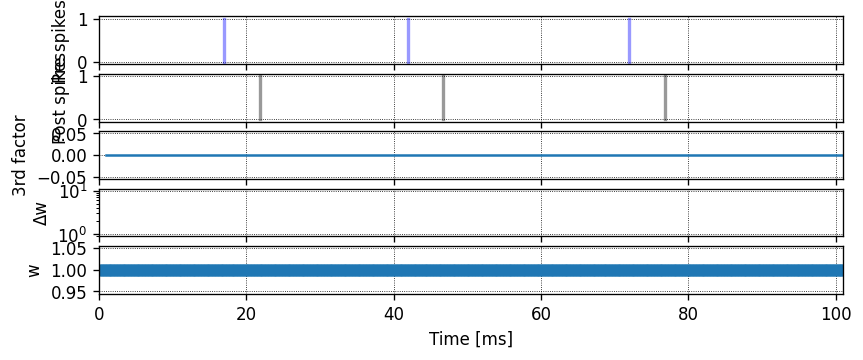

In [27]:
fname_snip = "detailed"

pre_spike_times = [15., 40., 70., 100.]      # [ms]
post_spike_times = [20., 45., 75.]      # [ms]

# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(neuron_model_name=neuron_model_name,
                        synapse_model_name=synapse_model_name,
                        resolution=.1,  # [ms]
                        delay=1.,  # [ms]
                        pre_spike_times=pre_spike_times,
                        post_spike_times=post_spike_times,
                        sim_time=101.,
                        fname_snip=fname_snip,
                        stepwise_times=[0.], stepwise_values=[0.])

# verify that weight stays zero: buffering ensures that the value of I_dend at the right time is used
#np.testing.assert_allclose(w_hist, 0.)

# idx = np.where(np.abs(third_factor_trace) < 1E-12)[0]  # find where third_factor_trace is (almost) zero
# times_dw_should_be_zero = timevec[idx]
# assert len(times_dw_should_be_zero) > 0  # make sure we have > 0 datapoints to check
# for time_dw_should_be_zero in times_dw_should_be_zero[1:]:
#     _idx = np.argmin((time_dw_should_be_zero - np.array(t_hist))**2)
#     np.testing.assert_allclose(t_hist[_idx], time_dw_should_be_zero)
#     np.testing.assert_allclose(0., np.abs(w_hist[_idx - 1] - w_hist[_idx]))   # make sure that weight does not change appreciably





              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Nov  8 2023 01:11:46

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[94,GLOBAL, INFO]: The NEST Simulator version was automatically detected as: master
Pre spike times: [15.0, 40.0, 70.0, 100.0]
Post spike times: [20.0, 45.0, 75.0]


Actual pre spike times: [ 16.  41.  71. 101.]
Actual post spike times: [21.8 46.7 76.8]


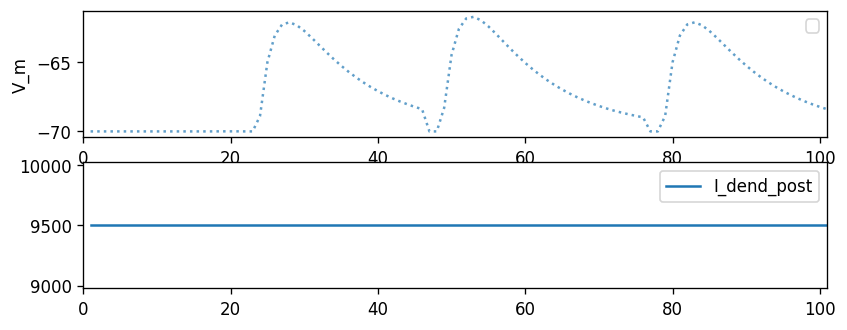

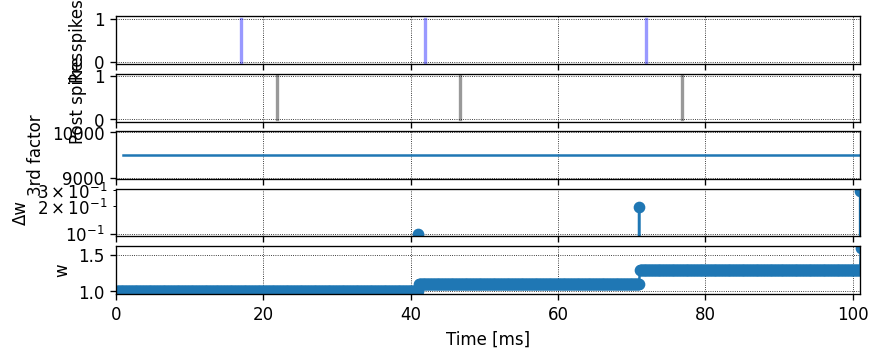

In [21]:

# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(neuron_model_name=neuron_model_name,
                        synapse_model_name=synapse_model_name,
                        resolution=.1,  # [ms]
                        delay=1.,  # [ms]
                        pre_spike_times=pre_spike_times,
                        post_spike_times=post_spike_times,
                        sim_time=101.,
                        fname_snip=fname_snip,
                        stepwise_times=[0.], stepwise_values=[9999.])



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Nov  8 2023 01:11:46

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[98,GLOBAL, INFO]: The NEST Simulator version was automatically detected as: master
Pre spike times: [15.0, 40.0, 70.0, 100.0]
Post spike times: [20.0, 45.0, 75.0]


Actual pre spike times: [ 16.  41.  71. 101.]
Actual post spike times: [21.8 46.7 76.8]


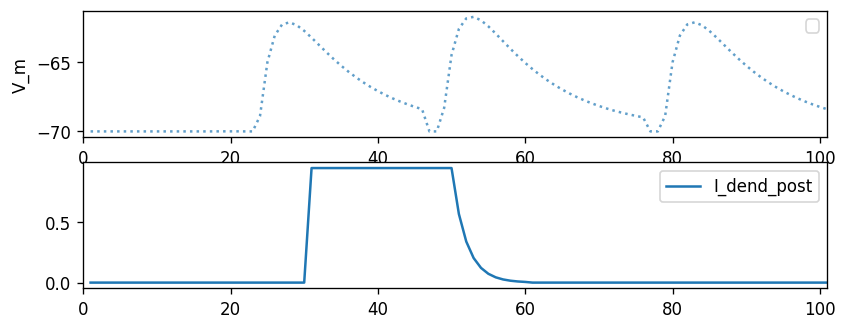

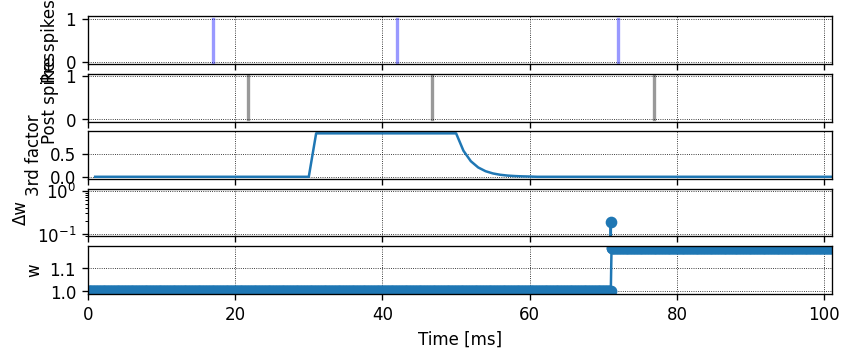

In [28]:
# run the simulation
sim_time = 101.
stepwise_times = [0.,
                  30.,
                  50.,
                  60.]

stepwise_values = [0., 1., None, 0.]


timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(neuron_model_name=neuron_model_name,
                synapse_model_name=synapse_model_name,
                resolution=.1,  # [ms]
                delay=1.,  # [ms]
                pre_spike_times=pre_spike_times,
                post_spike_times=post_spike_times,
                sim_time=sim_time,
                fname_snip=fname_snip,
                stepwise_times=stepwise_times, stepwise_values=stepwise_values)



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Nov  8 2023 01:11:46

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[107,GLOBAL, INFO]: The NEST Simulator version was automatically detected as: master
Pre spike times: [15.0, 40.0, 70.0, 100.0]
Post spike times: [20.0, 45.0, 75.0]


Actual pre spike times: [ 16.  41.  71. 101.]
Actual post spike times: [21.8 46.7 76.8]


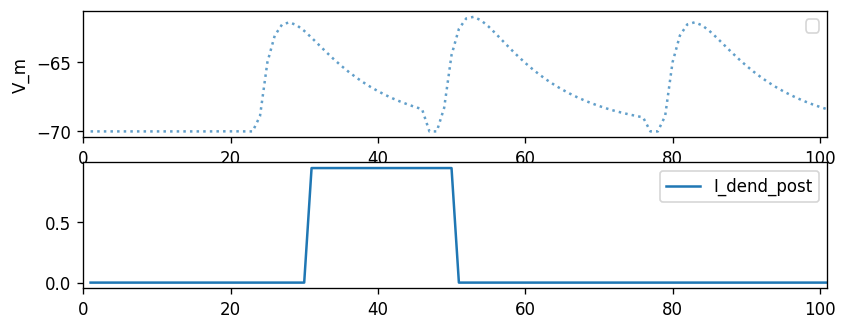

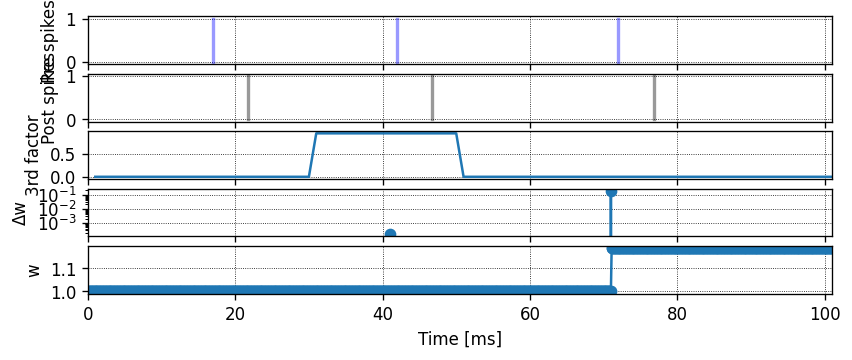

In [41]:
# run the simulation
sim_time = 101.
stepwise_times = [0.,
                  30.,
                  50.,
                  60.]

stepwise_values = [0., 1., 0., 0.]


timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(neuron_model_name=neuron_model_name,
                synapse_model_name=synapse_model_name,
                resolution=.1,  # [ms]
                delay=1.,  # [ms]
                pre_spike_times=pre_spike_times,
                post_spike_times=post_spike_times,
                sim_time=sim_time,
                fname_snip=fname_snip,
                stepwise_times=stepwise_times, stepwise_values=stepwise_values)


References
----------

...







